# Load the data
## Prerequisite
We assume that in the loaded folder there is two files named BatchCycle.csv and TimeTraceFull.pkl. 
The BatchCycle.csv is assumed to be constructed the following way:
- Each measurement should have 5 columns and each measurement is stacked on the column’s axis so for two measurement you should have eight columns
- For each measurement you should have in order the cycle number, the time of exposure, the power send to the sample, the associated power on the pulse picker, and a synchronisation time which is the pythonic time when the transition to the new state is done
- Each line then corresponds to a cycle within a measurement 

The TimeTraceFull.pkl contains all the time trace for each measurements. It takes advantages of the multindex in pandas dataframe.

## Loading the python libraries   



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib as mat
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import glob as glob

## Defining some useful variables

In [2]:
#FileDir='./'
#FileDir='/home/anton/remote/data/EnhancePerov/'
FileDir='/export/scratch2/constellation-data/EnhancePerov/'
FileNameCycle=FileDir+'BatchCycle.csv'
FileNameTimeTraceFull=FileDir+'TimeTraceFull.pkl'

## Loading the data

In [3]:
Cycle_info=pd.read_csv(FileNameCycle)
TimeTraceFull=pd.read_pickle(FileNameTimeTraceFull,compression='xz')
TimeTraceFull.columns=TimeTraceFull.columns.astype(float)
WavelengthFilter= [col for col in TimeTraceFull.columns if 600 <= col <= 900]
TimeTraceU=TimeTraceFull[WavelengthFilter].sum(axis=1).unstack(level=0)

### Calculating experiment info

In [4]:

Nb_pts=int(TimeTraceU.shape[1])
colors = sns.color_palette("coolwarm", Nb_pts)
p_cyc=pd.DataFrame(index=range(10), columns=range(Nb_pts))
TimeSync=pd.DataFrame(index=range(10), columns=range(Nb_pts))
TimeCycle=pd.DataFrame(index=range(10), columns=range(Nb_pts))

for i in range(Nb_pts):
    if i==0:
        p_cyc.iloc[:,i]=Cycle_info.loc[:,'Power send']
        TimeCycle.iloc[:,i]=Cycle_info.loc[:,'Exposure Time']
        TimeSync.iloc[:,i]=Cycle_info.loc[:,'Sync']

    else:
        p_cyc.iloc[:,i]=Cycle_info.loc[:,'Power send.{}'.format(i)]
        TimeCycle.iloc[:,i]=Cycle_info.loc[:,'Exposure Time.{}'.format(i)]
        TimeSync.iloc[:,i]=Cycle_info.loc[:,'Sync.{}'.format(i)]


t_global=pd.Series(TimeCycle.cumsum().iloc[-1,:],index=range(Nb_pts))

Pos=np.zeros([Nb_pts,2])
for i in range(Nb_pts):
    x_temp=float(glob.glob(FileDir+'Mes*')[i].split('x=')[1].split('y=')[0])
    y_temp=float(glob.glob(FileDir+'Mes*')[i].split('y=')[1])
    Pos[i,:]=[x_temp,y_temp]


### Aligning time tag (if necessary)

In [5]:
#TimeI=TimeTraceU.iloc[:,0].dropna().index
#TimeTrace=pd.DataFrame()

#for i in range (Nb_pts):
#    TimeTrace=pd.concat([TimeTrace,TimeTraceU.iloc[:,i].dropna().reindex(index=TimeI,method='nearest')],axis=1)
     



### Fitting spectra

In [ ]:



def Gaussian(x, a, b, c,d):
    return np.array(a * np.exp(-0.5*np.power((x-b)/(c), 2))+d, dtype='float32')

def FittingGaussian(data):
    '''This function take a 2D dataframe containing raw PL spectra  find the peak position and return it. 
    The data is assumed to have the following dimension (Time,Wavelength).'''
    ResultFit=pd.DataFrame(np.zeros(data.shape),columns=data.columns,index=data.index)

    TimeTraceFit=pd.DataFrame(np.zeros(data.shape[0]),index=data.index)
    pi=[1, 700, 50,0.1]
    bounds=((1E-6,600,1,1E-6),(data.max(axis=None),900,100,1))

    for time in data.index:
        data_fit_Gaussian = data.loc[time].rolling(20,min_periods=1).mean()
        try:
            popt, _,_,msg,ier = curve_fit(Gaussian, data_fit_Gaussian.index.to_numpy(), data_fit_Gaussian.to_numpy(),
                                p0=pi,bounds=bounds,full_output=True)
            temp=pd.Series(Gaussian(data_fit_Gaussian.index.to_numpy(), popt[0], popt[1], popt[2],popt[3]),index=data_fit_Gaussian.index)
            if ier not in [1,2,3,4]:
                print(msg)                
                temp=pd.Series(np.zeros(len(data_fit_Gaussian.index.to_numpy())),index=data_fit_Gaussian.index)                          
        except Exception as e:
            print(e)
            temp=pd.Series(np.zeros(len(data_fit_Gaussian.index.to_numpy())),index=data_fit_Gaussian.index)
        
        ResultFit.loc[time,:]=temp.T
        TimeTraceFit.loc[time]=quad(Gaussian,popt[1]-popt[2],popt[1]+popt[2],args=(popt[0], popt[1], popt[2],popt[3]))[0]

    return ResultFit,TimeTraceFit

TimeTraceFullFit=pd.DataFrame()
TimeTraceFit=pd.DataFrame()

for i in TimeTraceFull.index.get_level_values('Mes').drop_duplicates():
    ResultFit,TimeTraceFit_temp=FittingGaussian(TimeTraceFull.xs(i,level='Mes'))
    ResultFit['Mes']=i
    TimeTraceFullFit=pd.concat((TimeTraceFullFit,ResultFit))
    TimeTraceFit_temp['Mes']=i
    TimeTraceFit=pd.concat((TimeTraceFit,TimeTraceFit_temp))
    print('Measurement {}'.format(i))

TimeTraceFit.to_pickle(FileDir+'TimeTraceFit.pkl')
TimeTraceFullFit.to_pickle(FileDir+'TimeTraceFullFit.pkl',compression='xz')

# Plots

## Plot all the Time trace

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_526425/558655803.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('Power[$\mu$W]')
/tmp/ipykernel_526425/558655803.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim([0,1E3])
/tmp/ipykernel_526425/558655803.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('Power[$\mu$W]')


KeyboardInterrupt: 

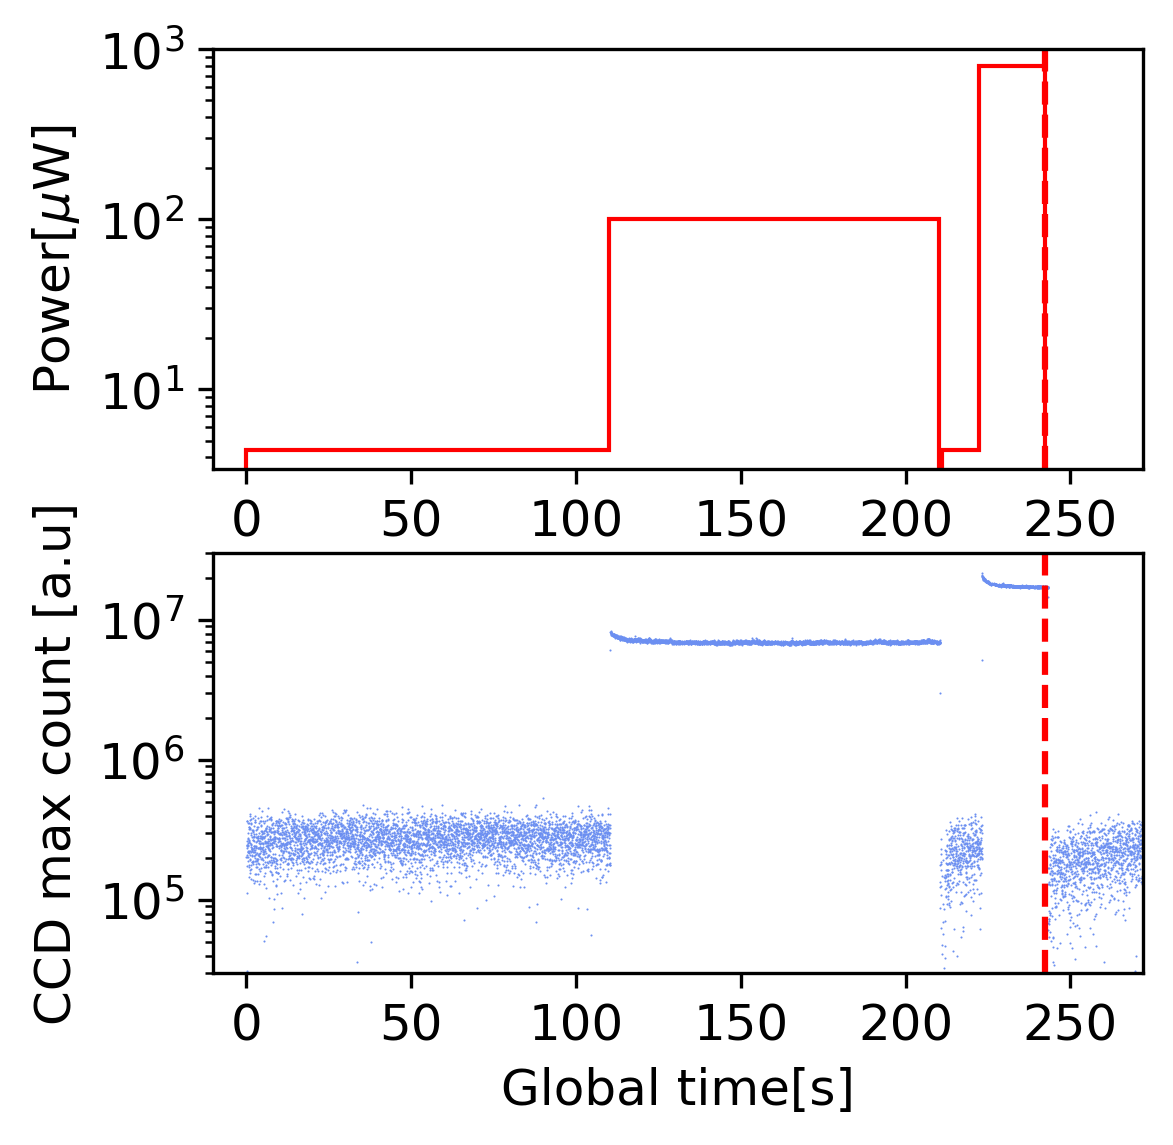

In [6]:
mat.rcParams.update({'font.size': 12, 'font.family': 'sans-serif',
                         'xtick.labelsize': 12, 'ytick.labelsize': 12,
                           'figure.dpi': 300, 'savefig.dpi': 300,
                             'figure.figsize': (10/2.5,10/2.5)})

Folder = glob.glob(FileDir+'Mes*')

for i in range(len(Folder)):
    fig1,ax=plt.subplots(2,1)

    ax[0].stairs(pd.to_numeric(p_cyc.iloc[:,i],errors='coerce'),np.insert(TimeCycle.cumsum().iloc[:,i].to_numpy(),0,0),color='red')
    ax[0].set_yscale('log')
    ax[0].set_ylim([0,1E3])
    ax[0].set_xlim([-10,TimeTraceU.iloc[:,i].dropna().index.max()])
    ax[0].plot([t_global[i],t_global[i]],ax[0].get_ylim(),'--',color='red')
    ax[0].set_ylabel('Power[$\mu$W]')



    ax[1].plot(TimeTraceU.iloc[:,i].dropna(),'.',markersize=1,markeredgewidth=0,color=colors[i])


    ax[1].set_yscale('log')
    ax[1].set_ylim([3E4,3E7])
    ax[1].set_xlim([-10,TimeTraceU.iloc[:,i].dropna().index.max()])
    ax[1].plot([t_global[i],t_global[i]],ax[1].get_ylim(),'--',color='red')

    ax[1].set_ylabel('CCD max count [a.u]')
    ax[1].set_xlabel('Global time[s]')
    
    plt.tight_layout()
    plt.savefig('{}/TimeTraceSumExp.png'.format(Folder[i]))
    plt.close()




<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_526425/3026096500.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x [$\mu$ m]')
/tmp/ipykernel_526425/3026096500.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y [$\mu$m]')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not 

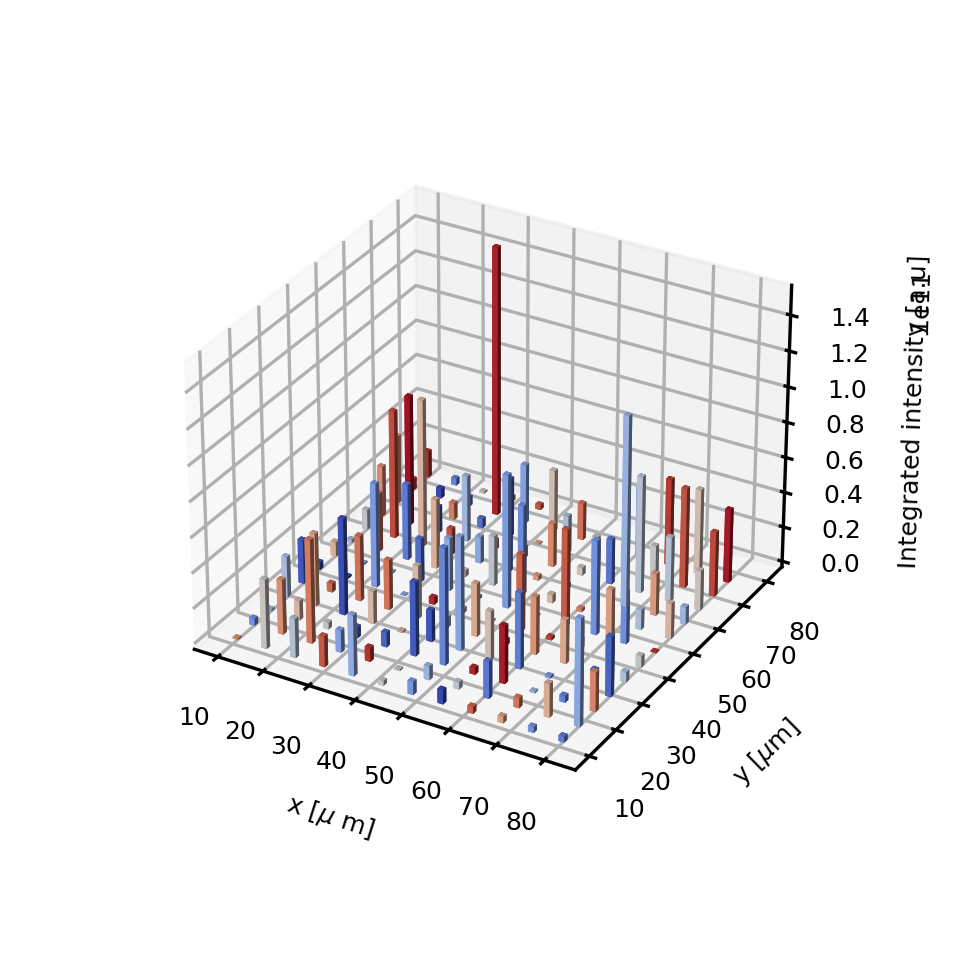

In [27]:
%matplotlib widget 
mat.rcParams.update({'font.size': 6, 'font.family': 'sans-serif',
                         'xtick.labelsize': 6, 'ytick.labelsize': 6,
                           'figure.dpi': 300, 'savefig.dpi': 300,
                             'figure.figsize': (8/2.5,8/2.5)})

fig,ax=plt.subplots(1,1,subplot_kw={"projection": "3d"})

for i in range(Nb_pts-1):
    ax.bar3d(Pos[i,0],Pos[i,1],0,1.2,1.2,TimeTraceU.iloc[:,i].dropna().sum(),color=colors[i])



ax.set_zlabel('Integrated intensity [a.u]')
ax.set_xlabel('x [$\mu$ m]')
ax.set_ylabel('y [$\mu$m]')
ax.set_box_aspect(None, zoom=0.75)
plt.tight_layout()
plt.savefig('PositionDependance.png')

In [29]:
ML_Obs=pd.DataFrame({'Int stability':np.zeros(Nb_pts),'Int integrated':np.zeros(Nb_pts)},index=range(Nb_pts))

for i in range(Nb_pts):
    temp_df=TimeTraceU.iloc[:,i].dropna()
    integrated_int=temp_df.sum()
    ts=np.argmin(np.abs(temp_df.index-t_global[i]))

    ML_Obs.loc[i]=[temp_df.iloc[ts:].mean(axis=0),integrated_int]

mat.rcParams.update({'font.size': 6,
                         'xtick.labelsize': 6, 'ytick.labelsize': 6,
                           'figure.dpi': 300, 'savefig.dpi': 300,
                             'figure.figsize': (7/2.5,5/2.5)})

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

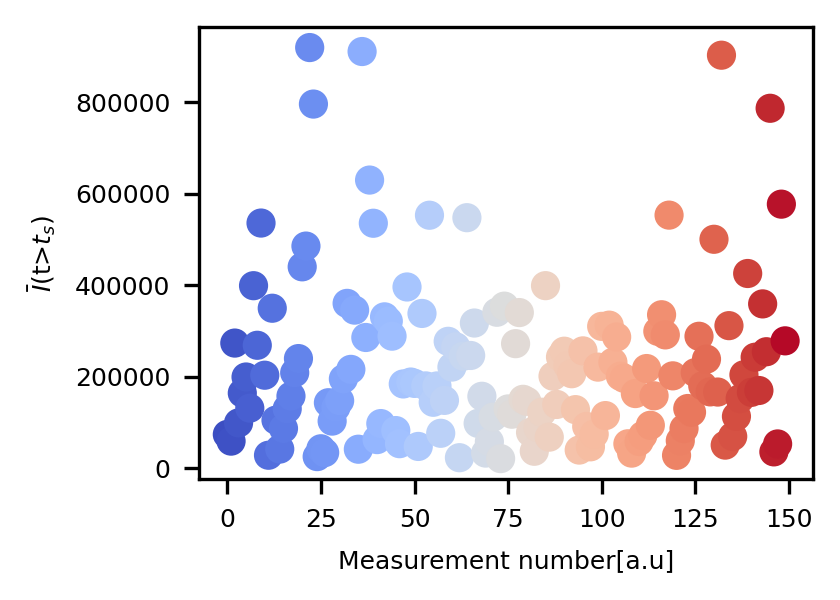

In [30]:
fig1,ax=plt.subplots(1,1)
ax.scatter(ML_Obs.index,ML_Obs['Int stability'],color=colors)
ax.set_ylabel('$\\bar{I}$(t>$t_s$)')
ax.set_xlabel('Measurement number[a.u]')
plt.tight_layout()
plt.savefig('StabilityRegion.png')

In [31]:
print(ML_Obs.to_string())

     Int stability  Int integrated
0     73551.085938    1.057098e+09
1     58899.750000    8.047928e+09
2    273315.218750    5.661030e+09
3     98696.265625    4.288645e+09
4    163958.984375    5.486793e+10
5    199097.671875    1.526639e+10
6    130982.906250    1.782427e+10
7    398767.500000    2.501475e+10
8    268464.812500    4.200491e+10
9    535736.625000    6.329196e+09
10   203008.281250    2.687446e+10
11    28031.279297    3.348694e+10
12   349473.156250    3.390423e+10
13   104817.937500    8.311990e+09
14    41485.894531    5.457246e+09
15    86616.593750    2.471344e+10
16   129619.531250    1.705358e+09
17   157355.484375    5.370693e+09
18   208426.984375    2.649404e+09
19   239397.781250    2.569005e+10
20   440019.656250    2.108792e+10
21   485384.625000    3.240092e+09
22   919466.687500    4.343327e+10
23   795903.437500    4.318356e+10
24    25071.152344    3.721091e+09
25    42175.750000    4.014013e+09
26    33827.453125    6.603103e+10
27   142880.078125  

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

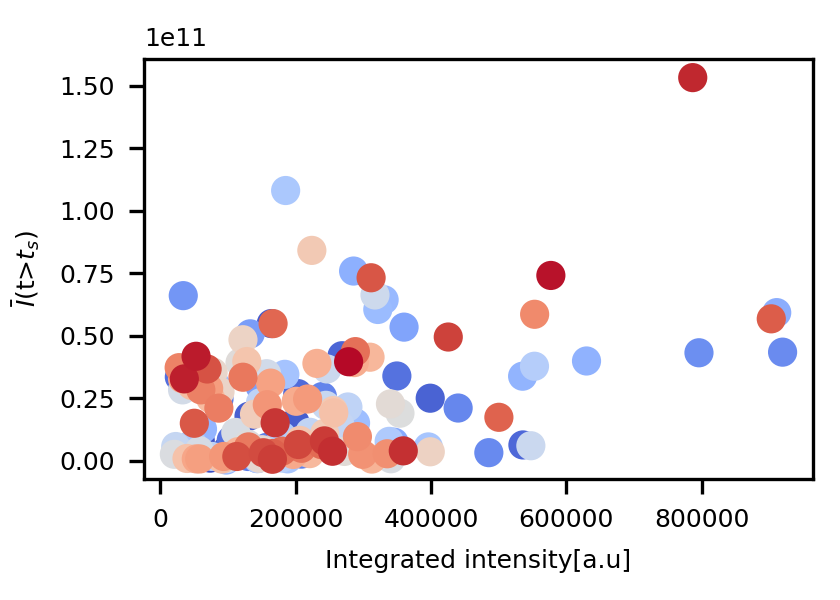

In [32]:
fig1,ax=plt.subplots(1,1)
ax.scatter(ML_Obs['Int stability'],ML_Obs['Int integrated'],color=colors)
ax.set_ylabel('$\\bar{I}$(t>$t_s$)')
ax.set_xlabel('Integrated intensity[a.u]')
plt.tight_layout()
plt.savefig('StabilityVSIntegrated.png')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

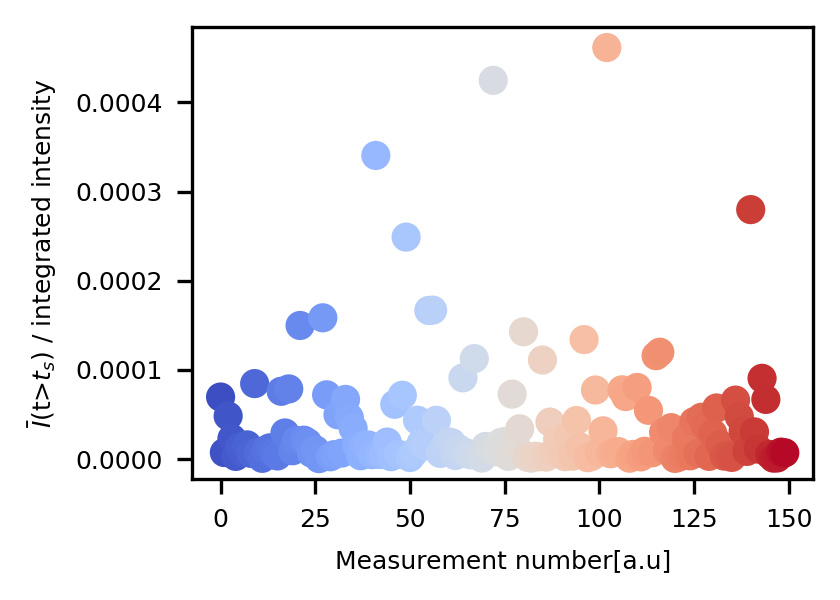

In [34]:
fig1,ax=plt.subplots(1,1)
ax.scatter(ML_Obs.index,ML_Obs['Int stability']/ML_Obs['Int integrated'],color=colors)
ax.set_ylabel('$\\bar{I}$(t>$t_s$) / integrated intensity')
ax.set_xlabel('Measurement number[a.u]')
plt.tight_layout()
plt.savefig('efficiencyMeasurements.png')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

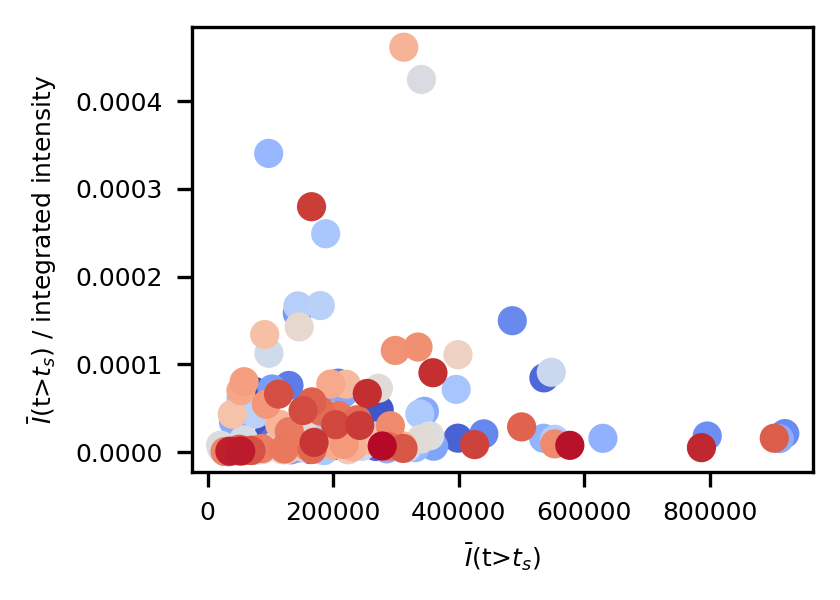

In [36]:
fig1,ax=plt.subplots(1,1)
ax.scatter(ML_Obs['Int stability'],ML_Obs['Int stability']/ML_Obs['Int integrated'],color=colors)
ax.set_ylabel('$\\bar{I}$(t>$t_s$) / integrated intensity')
ax.set_xlabel('$\\bar{I}$(t>$t_s$)')
plt.tight_layout()
plt.savefig('stabilityVSefficiency.png')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


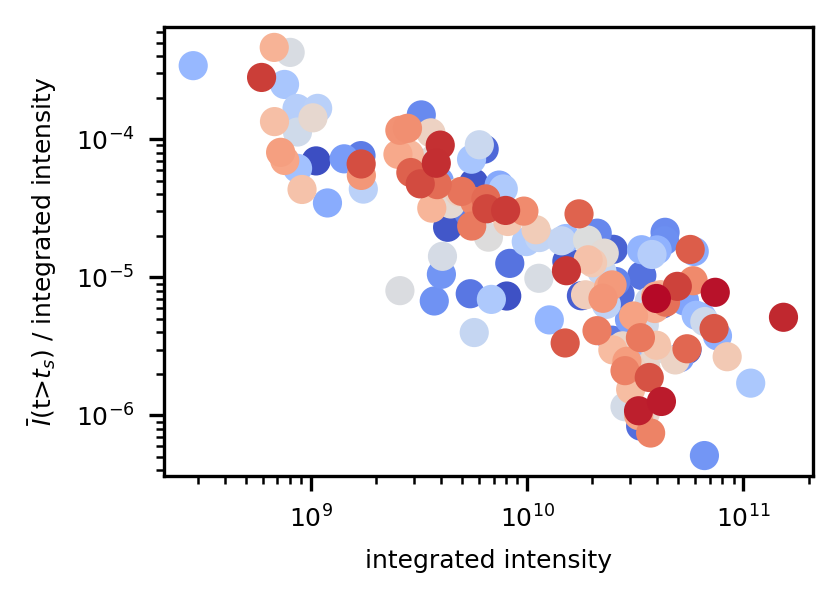

In [40]:
fig1,ax=plt.subplots(1,1)
ax.scatter(ML_Obs['Int integrated'],ML_Obs['Int stability']/ML_Obs['Int integrated'],color=colors)
ax.set_ylabel('$\\bar{I}$(t>$t_s$) / integrated intensity')
ax.set_xlabel('integrated intensity')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('integratedVSefficiency.png')